In [ ]:
# Import libraries
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

!pip install mord
from mord import LogisticIT

!pip install scikit-plot
import scikitplot as skplt
!pip install dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary, liftChart, gainsChart, adjusted_r2_score, backward_elimination, forward_selection, AIC_score, BIC_score
from dmba.metric import AIC_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Upload Dataset
autism_df = pd.read_csv('autism_df.csv')
autism_df.head()

ID  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   0         1         1         1         1         0         0         1   
1   1         1         1         0         1         0         0         0   
2   2         1         1         0         1         1         0         1   
3   3         1         1         0         1         0         0         1   
4   4         1         0         0         0         0         0         0   

   A8_Score  A9_Score  ...  age  gender       ethnicity jaundice  \
0         1         0  ...   26       f  White-European       no   
1         1         0  ...   24       m          Latino       no   
2         1         1  ...   27       m          Latino      yes   
3         1         0  ...   35       f  White-European       no   
4         1         0  ...   40       f          Others       no   

  autism_in_family country_of_res used_app_before result  relation Class/ASD  
0               no  United States              no      6      Self        NO  
1              yes         Brazil              no      5      Self        NO  
2              yes          Spain              no      8    Parent       YES  
3              yes  United States              no      6      Self        NO  
4               no          Egypt              no      2    Others        NO  

[5 rows x 21 columns]

In [ ]:
# Rename Class/ASD as Class_ASD
autism_df.rename(columns={'Class/ASD': 'Class_ASD'}, inplace=True)

In [ ]:
# Split the data into training and validation
x = autism_df.drop(columns=['ID', 'result', 'Class_ASD'])
y = autism_df['Class_ASD']
# Convert categorical variables to dummies
X = pd.get_dummies(x, drop_first=True)
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Create a Maximal Decision Tree
fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

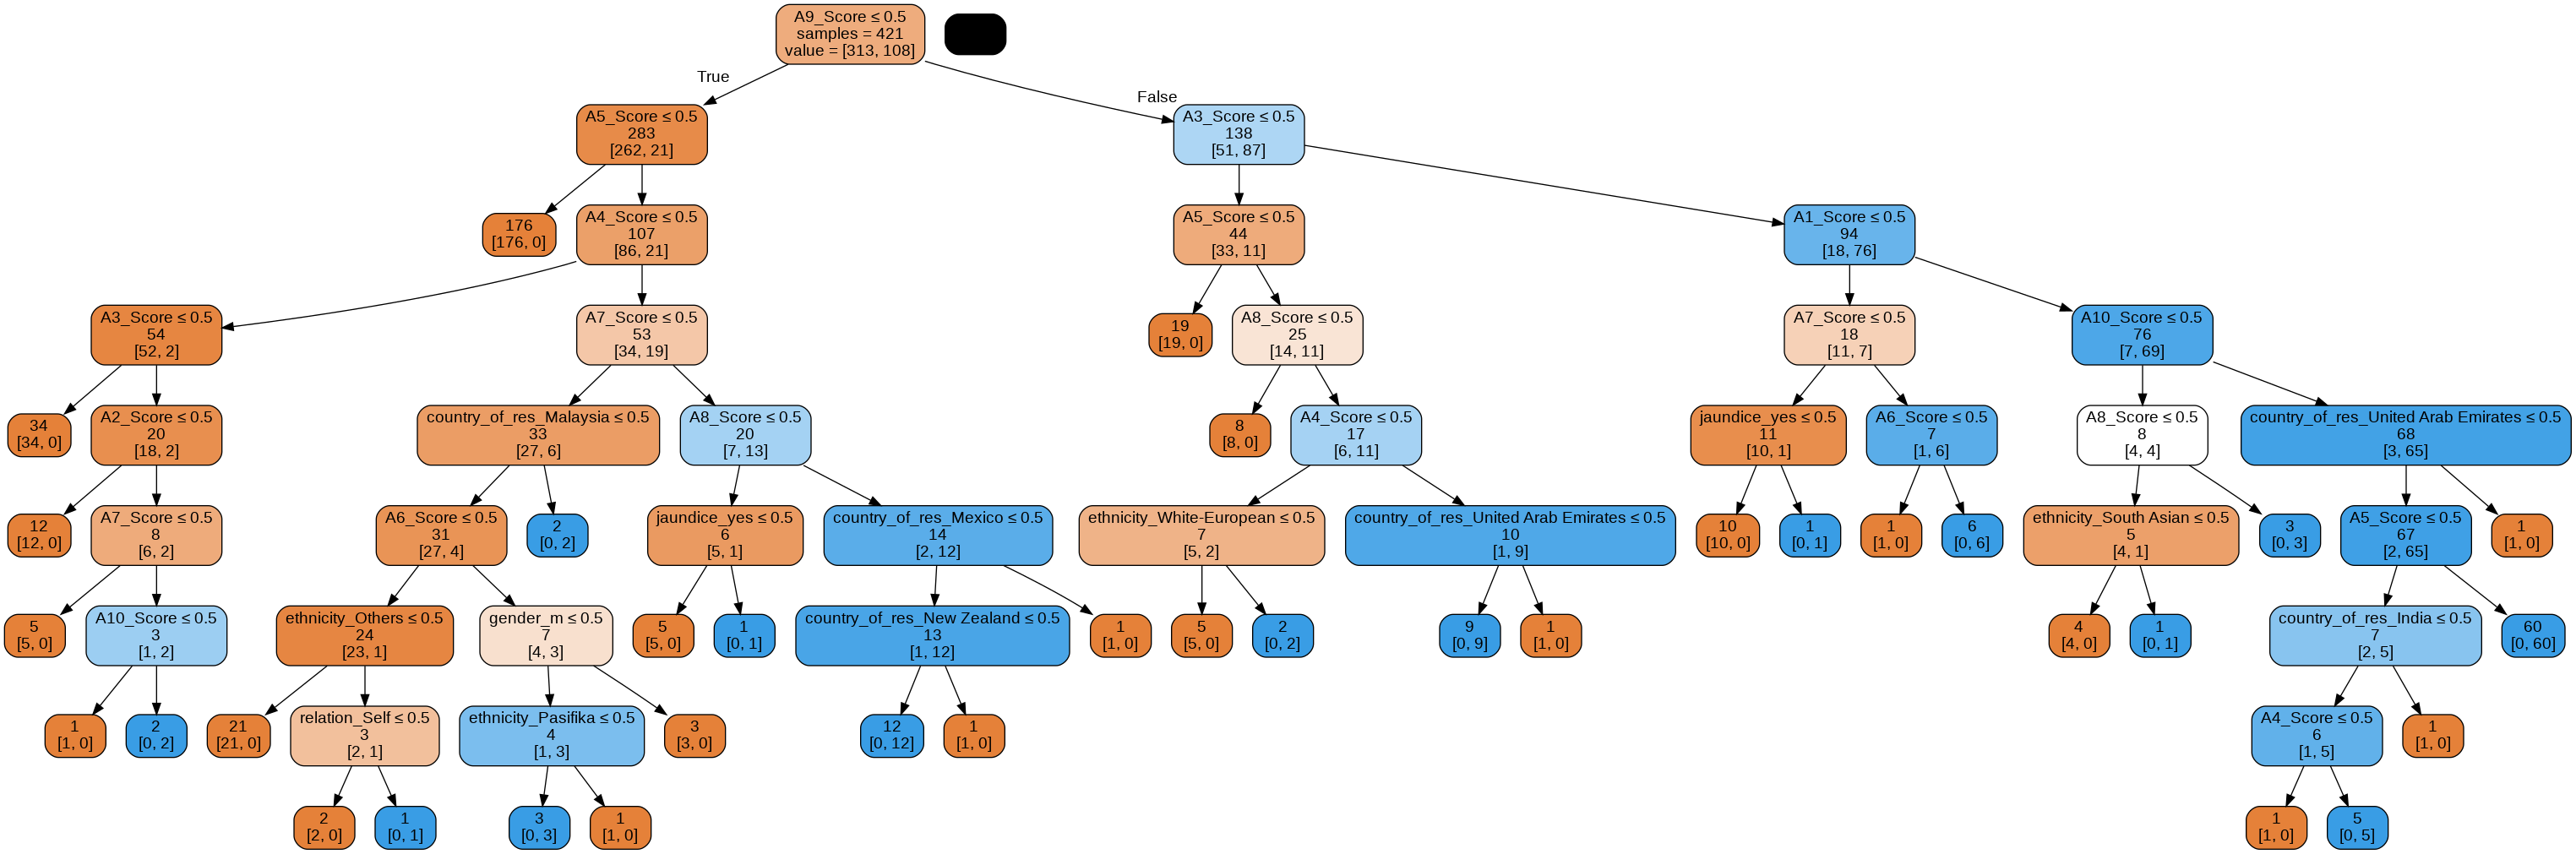

In [ ]:
# Plot the tree
plotDecisionTree(fullClassTree, feature_names=train_X.columns)

In [ ]:
# Check accuracy
classificationSummary(valid_Y,fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9220)

       Prediction
Actual   0   1
     0 191  10
     1  12  69


In [ ]:
# Set Decision Tree Paremeters 
param_grid = {
    'max_depth':[2, 3, 5, 8],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [ ]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 8],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 8, 'min_impurity_decrease': 0.001, 'min_samples_split': 0.005}

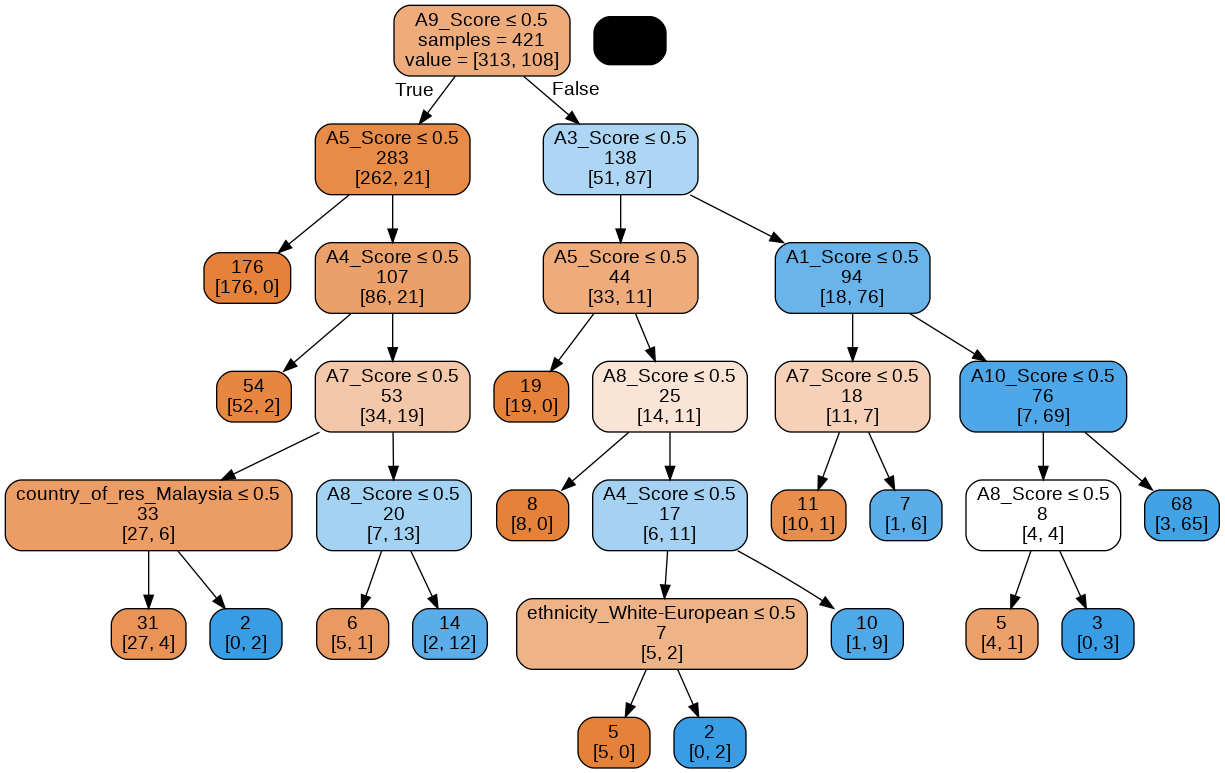

In [ ]:
# Create a new decision tree using optimal parameters
gridClassTree = DecisionTreeClassifier(max_depth=8, 
                                       min_impurity_decrease=0.005, 
                                       min_samples_split=0.01,
                                       random_state=1)
gridClassTree.fit(train_X, train_Y)
plotDecisionTree(gridClassTree, feature_names = train_X.columns)

In [ ]:
# Check Accuracy
classificationSummary(valid_Y, gridClassTree.predict(valid_X)) 
# Accuracy is lower than maximal tree but it is a better model because it is not overfitting

Confusion Matrix (Accuracy 0.9113)

       Prediction
Actual   0   1
     0 190  11
     1  14  67


In [ ]:
# Set random forest parameters 
param_grid = {
    'max_depth':[5, 8, 10],
    'min_samples_split': [0.01, 0.001, 0.0001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[300, 500, 700]
} 

In [ ]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.01, 0.001, 0.0001],
                         'n_estimators': [300, 500, 700]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 10,
 'min_impurity_decrease': 0.001,
 'min_samples_split': 0.01,
 'n_estimators': 700}

In [ ]:
# Create a random forest model using 500 samples
randomForest = RandomForestClassifier(random_state=1, n_estimators=700, min_impurity_decrease=0.001, min_samples_split=0.01, max_depth=10)
randomForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=10, min_impurity_decrease=0.001,
                       min_samples_split=0.01, n_estimators=700,
                       random_state=1)

In [ ]:
# Calculate the importance of each variable and the standard deviation
importance = randomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomForest.estimators_], axis=0)

In [ ]:
# Create dataframe of importance and standard deviation for each variable
randomForest_df = pd.DataFrame({'feature': train_X.columns,
                   'importance': importance,
                   'std': std})
print(randomForest_df.sort_values('importance', ascending=False))

                      feature  importance       std
8                    A9_Score    0.144486  0.173427
5                    A6_Score    0.143848  0.174352
4                    A5_Score    0.105866  0.121106
3                    A4_Score    0.091749  0.117589
2                    A3_Score    0.078869  0.101111
..                        ...         ...       ...
38       country_of_res_Chile    0.000000  0.000000
36     country_of_res_Burundi    0.000000  0.000000
33     country_of_res_Belgium    0.000000  0.000000
27       country_of_res_Aruba    0.000000  0.000000
59  country_of_res_Kazakhstan    0.000000  0.000000

[94 rows x 3 columns]


In [ ]:
# Check for accuracy
classificationSummary(valid_Y, randomForest.predict(valid_X))
# Accuracy is superior to decision trees

Confusion Matrix (Accuracy 0.9291)

       Prediction
Actual   0   1
     0 201   0
     1  20  61


In [ ]:
# Create dataframe of variables with importance greater than 0
important = randomForest_df[(randomForest_df['importance'] >= 0.05)]
important.value_counts()

feature    importance  std     
A10_Score  0.059460    0.083715    1
A3_Score   0.078869    0.101111    1
A4_Score   0.091749    0.117589    1
A5_Score   0.105866    0.121106    1
A6_Score   0.143848    0.174352    1
A7_Score   0.052393    0.067893    1
A9_Score   0.144486    0.173427    1
dtype: int64

In [ ]:
# Transform these variables into a list
feature_list = important['feature'].tolist()
len(feature_list)

7

In [ ]:
# Run a linear regression to predict Class_ASD
lin_reg = LinearRegression()
lin_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check the intercept, coefficients and calculate odds ratio
print('intercept', lin_reg.intercept_)
coef = pd.DataFrame({'coef': lin_reg.coef_[0], 'odds': np.e**lin_reg.coef_[0]}, index=X.columns)
print(coef.sort_values('odds', ascending = False))

intercept [-0.73002671]
                                   coef      odds
country_of_res_Sierra Leone    0.569060  1.766605
country_of_res_Nepal           0.527094  1.694002
country_of_res_Sweden          0.441237  1.554629
country_of_res_Viet Nam        0.417596  1.518307
country_of_res_Malaysia        0.413807  1.512566
...                                 ...       ...
country_of_res_Bolivia        -0.321020  0.725409
country_of_res_Czech Republic -0.453387  0.635472
country_of_res_Ecuador        -0.502330  0.605119
country_of_res_Hong Kong      -0.530698  0.588195
country_of_res_Bahamas        -0.569363  0.565886

[94 rows x 2 columns]


In [ ]:
# Check model accuracy
regressionSummary(valid_Y, lin_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.0108
Root Mean Squared Error (RMSE) : 0.2742
     Mean Absolute Error (MAE) : 0.2145


In [ ]:
# Install shap for visualization
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

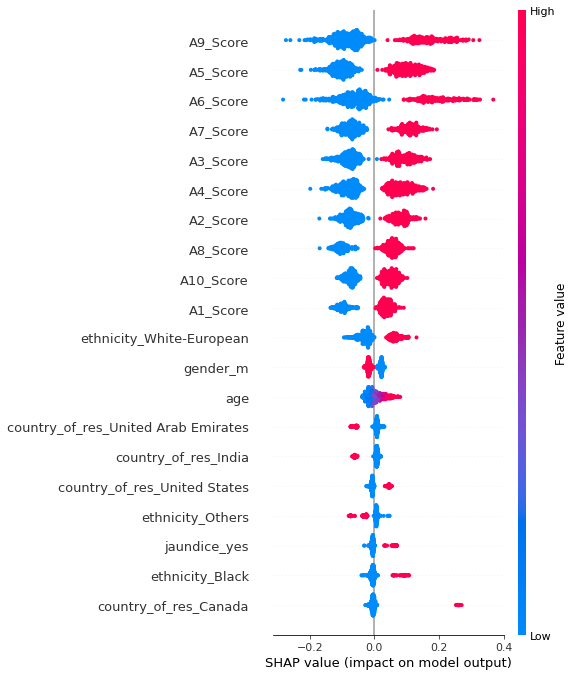

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(lin_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Reset the index of valid_Y
validY_reset = valid_Y.reset_index()
# Remove the index column
validY_reset.drop(columns='index', inplace=True)
validY_reset.head()

YES
0    0
1    0
2    1
3    1
4    0

In [ ]:
# Create a variable for model prediction
pred = lin_reg.predict(valid_X)

In [ ]:
# Create a dataframe for model predicitons
result = pd.DataFrame(pred, columns=['predicted'])

In [ ]:
# Concatenate the prediction and valid_Y dataframes
df1 = pd.concat([result, validY_reset], axis=1)
df1.head()

predicted  YES
0   0.081759    0
1  -0.068162    0
2   0.684777    1
3   0.881592    1
4   0.027152    0

<Figure size 504x360 with 0 Axes>

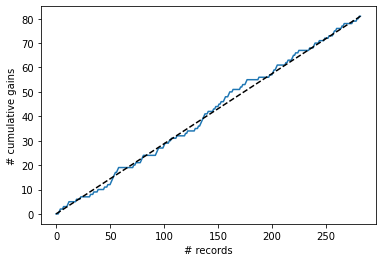

In [ ]:
# Plot a gains chart
plt.figure(figsize=(7,5))
gainsChart(df1.YES)
plt.show()

# Linear regression model is terrible

In [ ]:
# Run a logistic regression model
log_reg = LogisticRegression(solver='liblinear', C=1e42, random_state=1)
log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [ ]:
# Check the coefficients, intercept, and calcualte odds ratio
log_result = pd.DataFrame({'coef': log_reg.coef_[0], 'odds': np.e**log_reg.coef_[0]}, index=X.columns)
print('intercept', lin_reg.intercept_)
print(log_result.sort_values('odds', ascending=False))

intercept [-0.73002671]
                               coef           odds
A4_Score                  12.913161  405615.323854
A1_Score                  12.685488  323026.124497
A5_Score                  11.372498   86898.651784
A7_Score                  11.319376   82402.899214
A8_Score                  10.065906   23527.059044
...                             ...            ...
country_of_res_Pakistan   -3.909906       0.020042
relation_Parent           -4.095743       0.016643
relation_Self             -4.261023       0.014108
country_of_res_Hong Kong  -5.124486       0.005949
country_of_res_Jordan     -6.194366       0.002041

[94 rows x 2 columns]


In [ ]:
# Check model accuracy
classificationSummary(valid_Y, log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9894)

       Prediction
Actual   0   1
     0 201   0
     1   3  78


In [ ]:
# Run a Neural Network model with 2 hidden layers. Fit the model to training data
clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=2, random_state=1)
clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='logistic', hidden_layer_sizes=2, random_state=1,
              solver='lbfgs')

In [ ]:
# Check for accuracy
classificationSummary(valid_Y, clf.predict(valid_X))

Confusion Matrix (Accuracy 0.9574)

       Prediction
Actual   0   1
     0 195   6
     1   6  75


In [ ]:
# Look at model probability prediction
pd.DataFrame(clf.predict_proba(valid_X))

0             1
0    1.000000  3.772214e-10
1    1.000000  3.772214e-10
2    1.000000  3.930357e-10
3    0.017072  9.829276e-01
4    1.000000  3.772214e-10
..        ...           ...
277  1.000000  4.201857e-10
278  0.017072  9.829276e-01
279  1.000000  3.772214e-10
280  0.017073  9.829272e-01
281  1.000000  3.772214e-10

[282 rows x 2 columns]

In [ ]:
# Create a variable for model prediction probabilities
pred = clf.predict_proba(valid_X)

In [ ]:
# Run a cumulative gains chart
import scikitplot as skplt
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, pred)
plt.show()

In [ ]:
autism_df.columns

Index(['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
       'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'gender', 'ethnicity', 'jaundice', 'autism_in_family', 'country_of_res',
       'used_app_before', 'result', 'relation', 'Class_ASD'],
      dtype='object')

In [ ]:
# Split the dataset with Class/ASD as the target and only demographic variables as predictors
predictors = ['age', 'gender', 'ethnicity', 'jaundice', 'autism_in_family', 'country_of_res', 'used_app_before', 'relation']
x = autism_df[predictors]
y = autism_df['Class_ASD']
# Convert categorical variables to dummies
X = pd.get_dummies(x, drop_first=True)
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Run a maximal tree
fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check accuracy
classificationSummary(valid_Y, fullClassTree.predict(valid_X))
# Accuracy drops without the _Score variables

Confusion Matrix (Accuracy 0.7340)

       Prediction
Actual   0   1
     0 173  28
     1  47  34


In [ ]:
# Create parameters to optimize the tree
param_grid = {
    'max_depth':[5, 7, 8, 10, 11],
    'min_samples_split': [0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [ ]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 8, 10, 11],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.05, 0.01, 0.005, 0.001]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 8, 'min_impurity_decrease': 0.001, 'min_samples_split': 0.005}

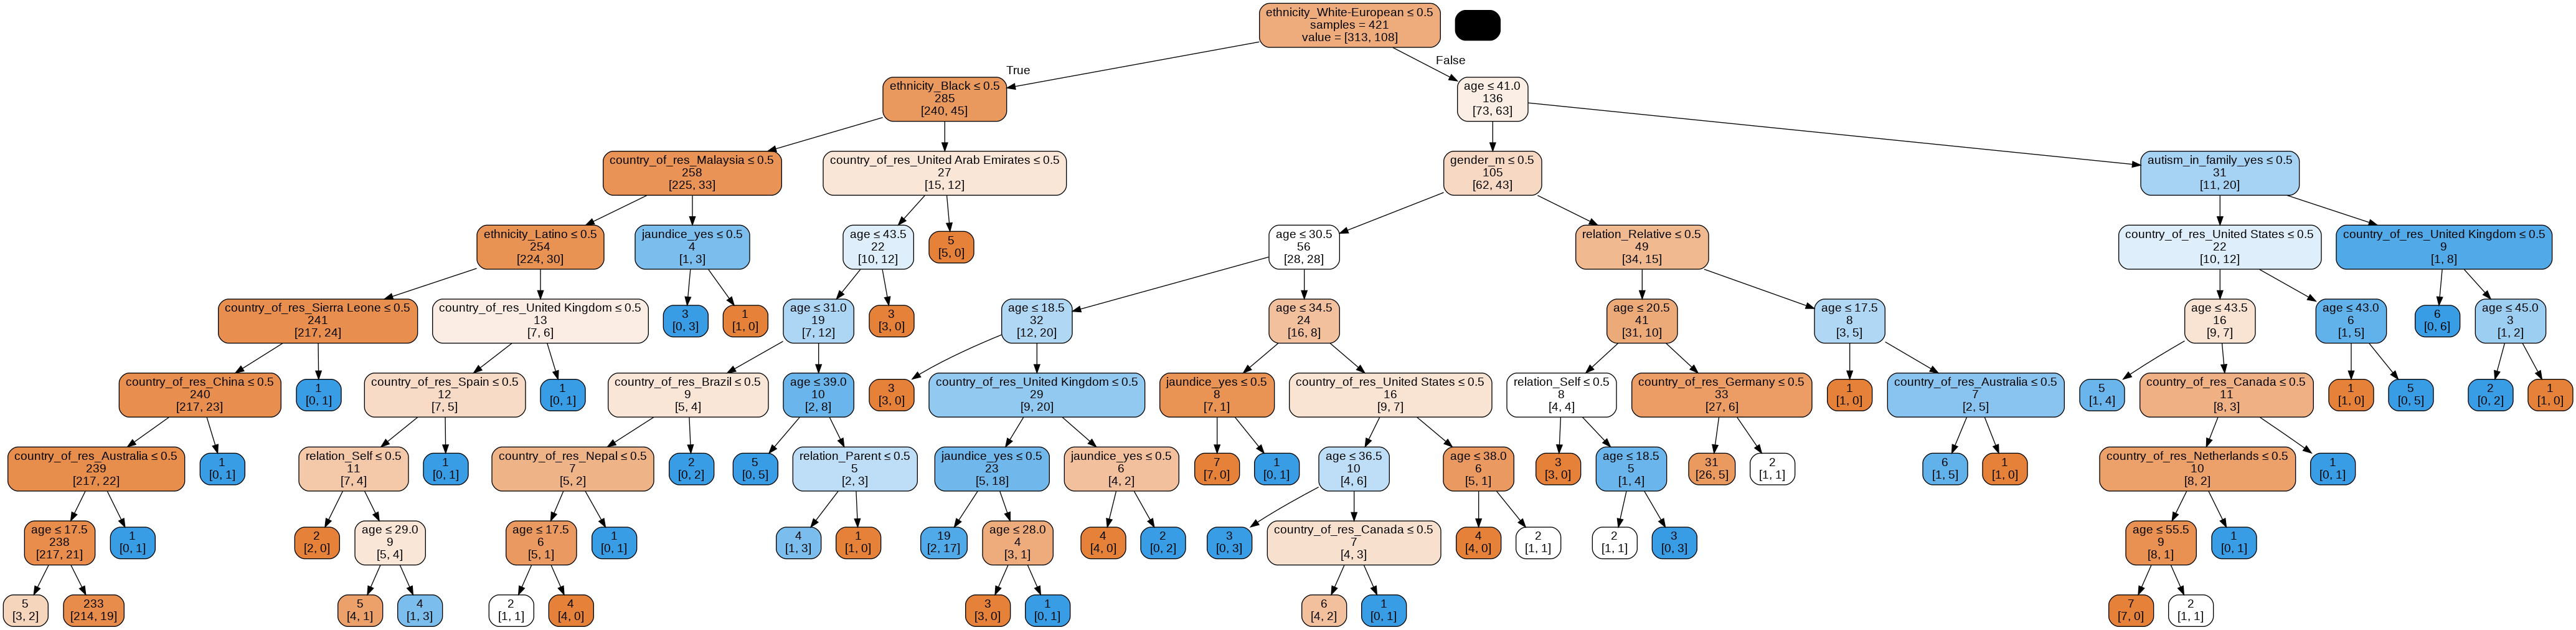

In [ ]:
# Optimize the decision tree and plot
gridClassTree = DecisionTreeClassifier(max_depth=8, 
                                       min_impurity_decrease=0.001, 
                                       min_samples_split=0.005,
                                       random_state=1)
gridClassTree.fit(train_X, train_Y)
plotDecisionTree(gridClassTree, feature_names = train_X.columns)

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, gridClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.7340)

       Prediction
Actual   0   1
     0 181  20
     1  55  26


In [ ]:
# Run a linear regression
cat_lin_reg = LinearRegression()
cat_lin_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check variable coefficients and odds ratio
cat_lin_result = pd.DataFrame({'coef': cat_lin_reg.coef_[0], 'odds': np.e**cat_lin_reg.coef_[0]}, index=X.columns)
print(cat_lin_result.sort_values('odds', ascending=False))

                                   coef      odds
country_of_res_China           0.933511  2.543423
country_of_res_Sierra Leone    0.880892  2.413050
country_of_res_Spain           0.871047  2.389411
country_of_res_Nepal           0.826616  2.285570
country_of_res_Austria         0.762439  2.143498
...                                 ...       ...
country_of_res_Armenia        -0.349976  0.704705
country_of_res_Czech Republic -0.350553  0.704299
country_of_res_Turkey         -0.354293  0.701670
country_of_res_Bolivia        -0.371597  0.689632
country_of_res_Ireland        -0.440656  0.643614

[84 rows x 2 columns]


In [ ]:
# Check model accuracy
regressionSummary(valid_Y, cat_lin_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.0217
Root Mean Squared Error (RMSE) : 0.4452
     Mean Absolute Error (MAE) : 0.3350


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

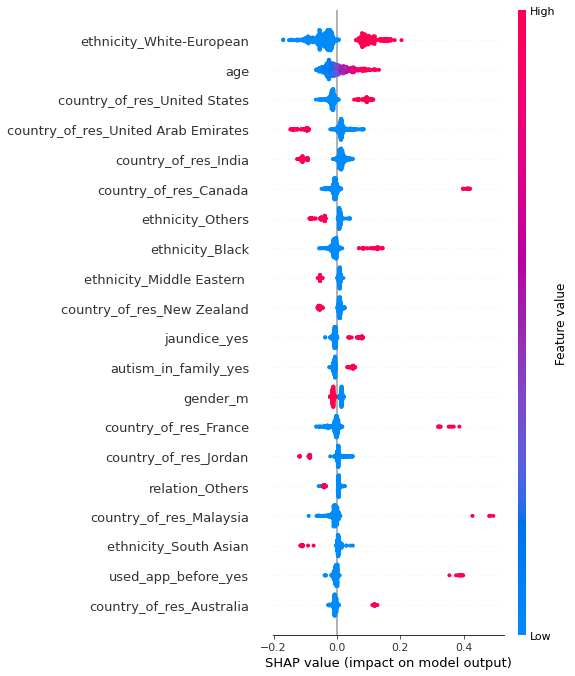

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(cat_lin_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Upload dataset containing continent of residence
continent = pd.read_csv('country_continent.csv')
continent.head()

contry_of_res continent_of_res
0  United States    North America
1         Brazil    South America
2          Spain           Europe
3  United States    North America
4          Egypt           Africa

In [ ]:
# Merge the autism dataset with the continent dataset using an inner join. Drop any duplicates
autism_df = pd.merge(autism_df, continent, how='inner', left_on=['country_of_res'], right_on=['contry_of_res']).drop_duplicates()
autism_df.shape

(703, 23)

In [ ]:
# Drop duplicate column
autism_df.drop(columns=['contry_of_res'], inplace=True)
autism_df.shape

(703, 22)

In [ ]:
# Split the dataset and use continent_or_res instead of country_of_res as a predictor
x = autism_df.drop(columns=['ID', 'country_of_res', 'result', 'Class_ASD'])
y = autism_df['Class_ASD']
# Convert categorical variables to dummies
X = pd.get_dummies(x, drop_first=True)
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Run a maximal tree
fullContinentTree = DecisionTreeClassifier(random_state=1)
fullContinentTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, fullContinentTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8794)

       Prediction
Actual   0   1
     0 179  13
     1  21  69


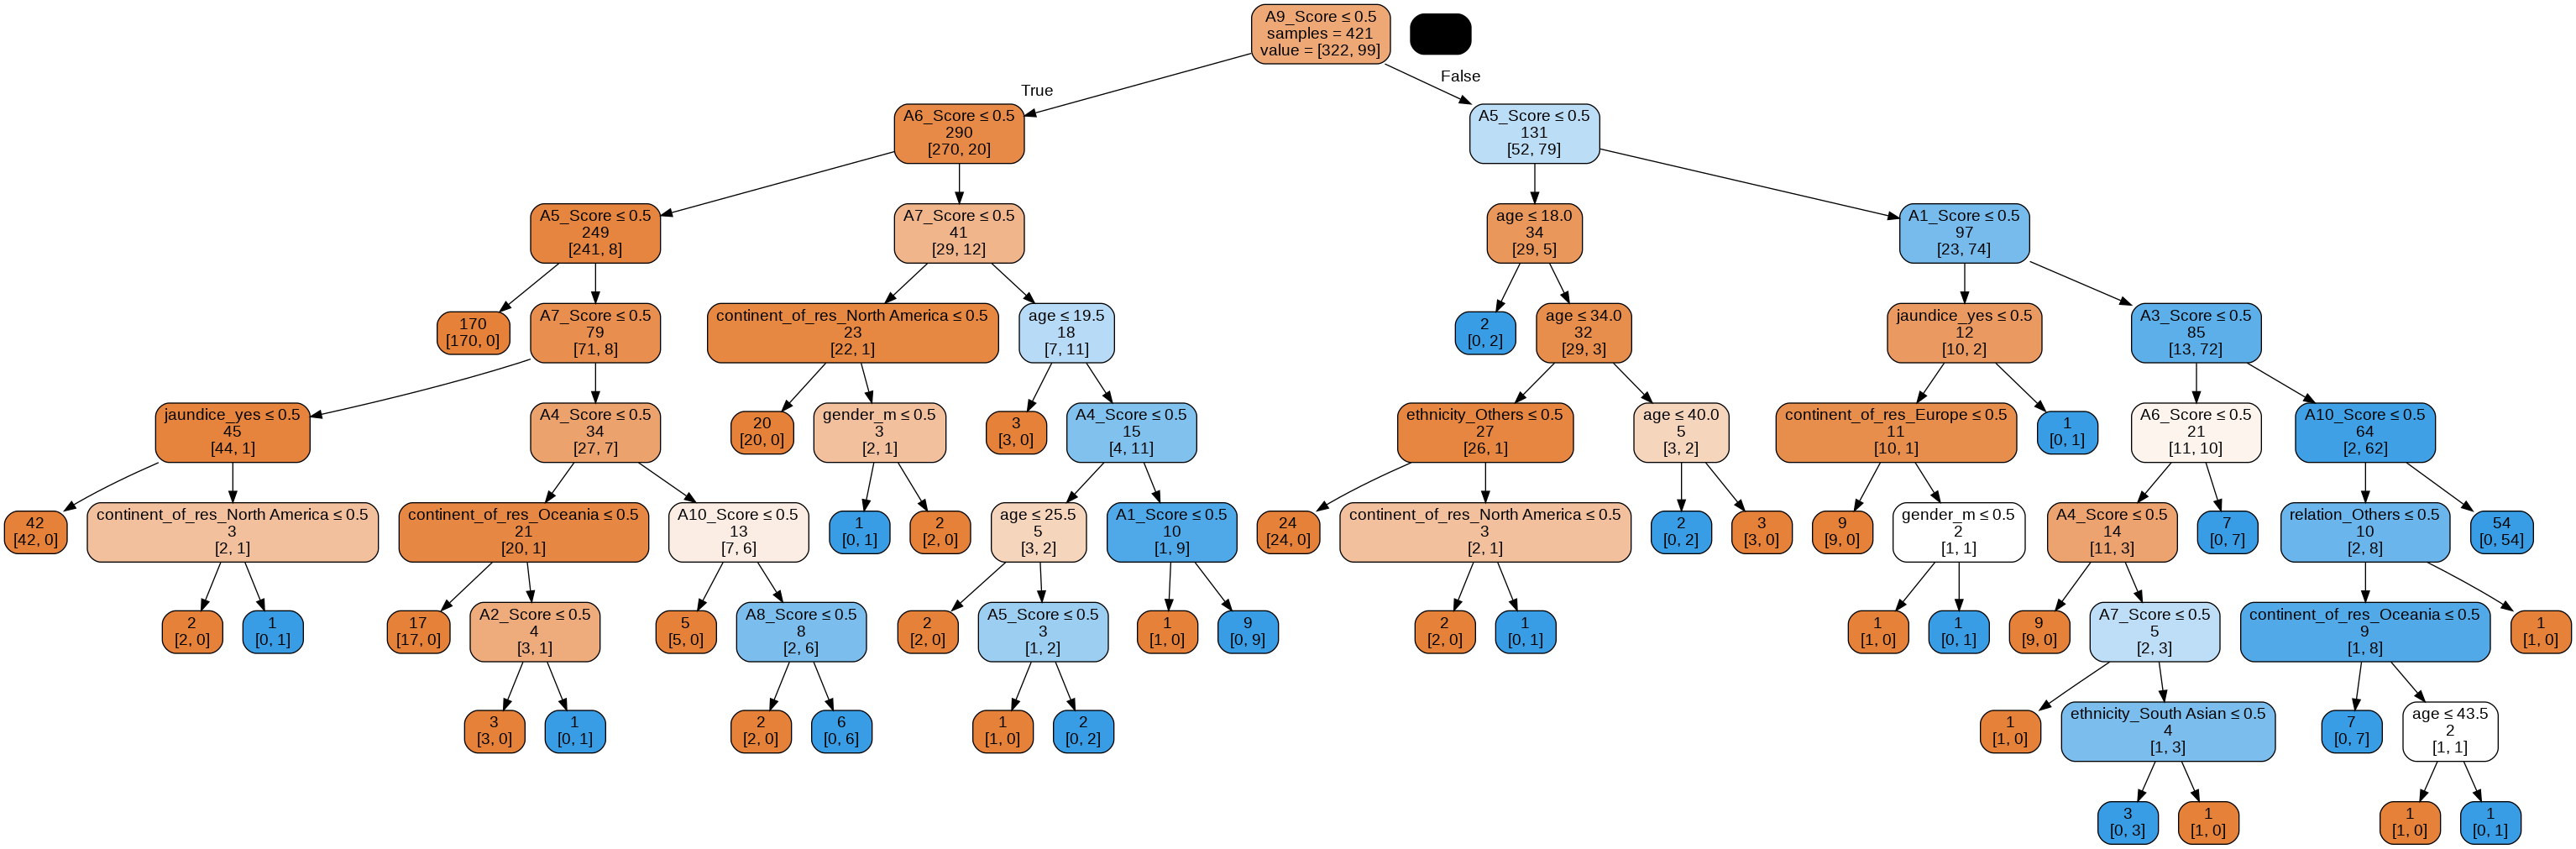

In [ ]:
# Plot the tree
plotDecisionTree(fullContinentTree, feature_names=train_X.columns)

In [ ]:
# Set parameters to optimize the tree
param_grid = {
    'max_depth':[3, 5, 7, 8, 9],
    'min_samples_split': [0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [ ]:
# Run a grid search to find the best optimizers
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.05, 0.01, 0.005, 0.001]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 9, 'min_impurity_decrease': 0.001, 'min_samples_split': 0.01}

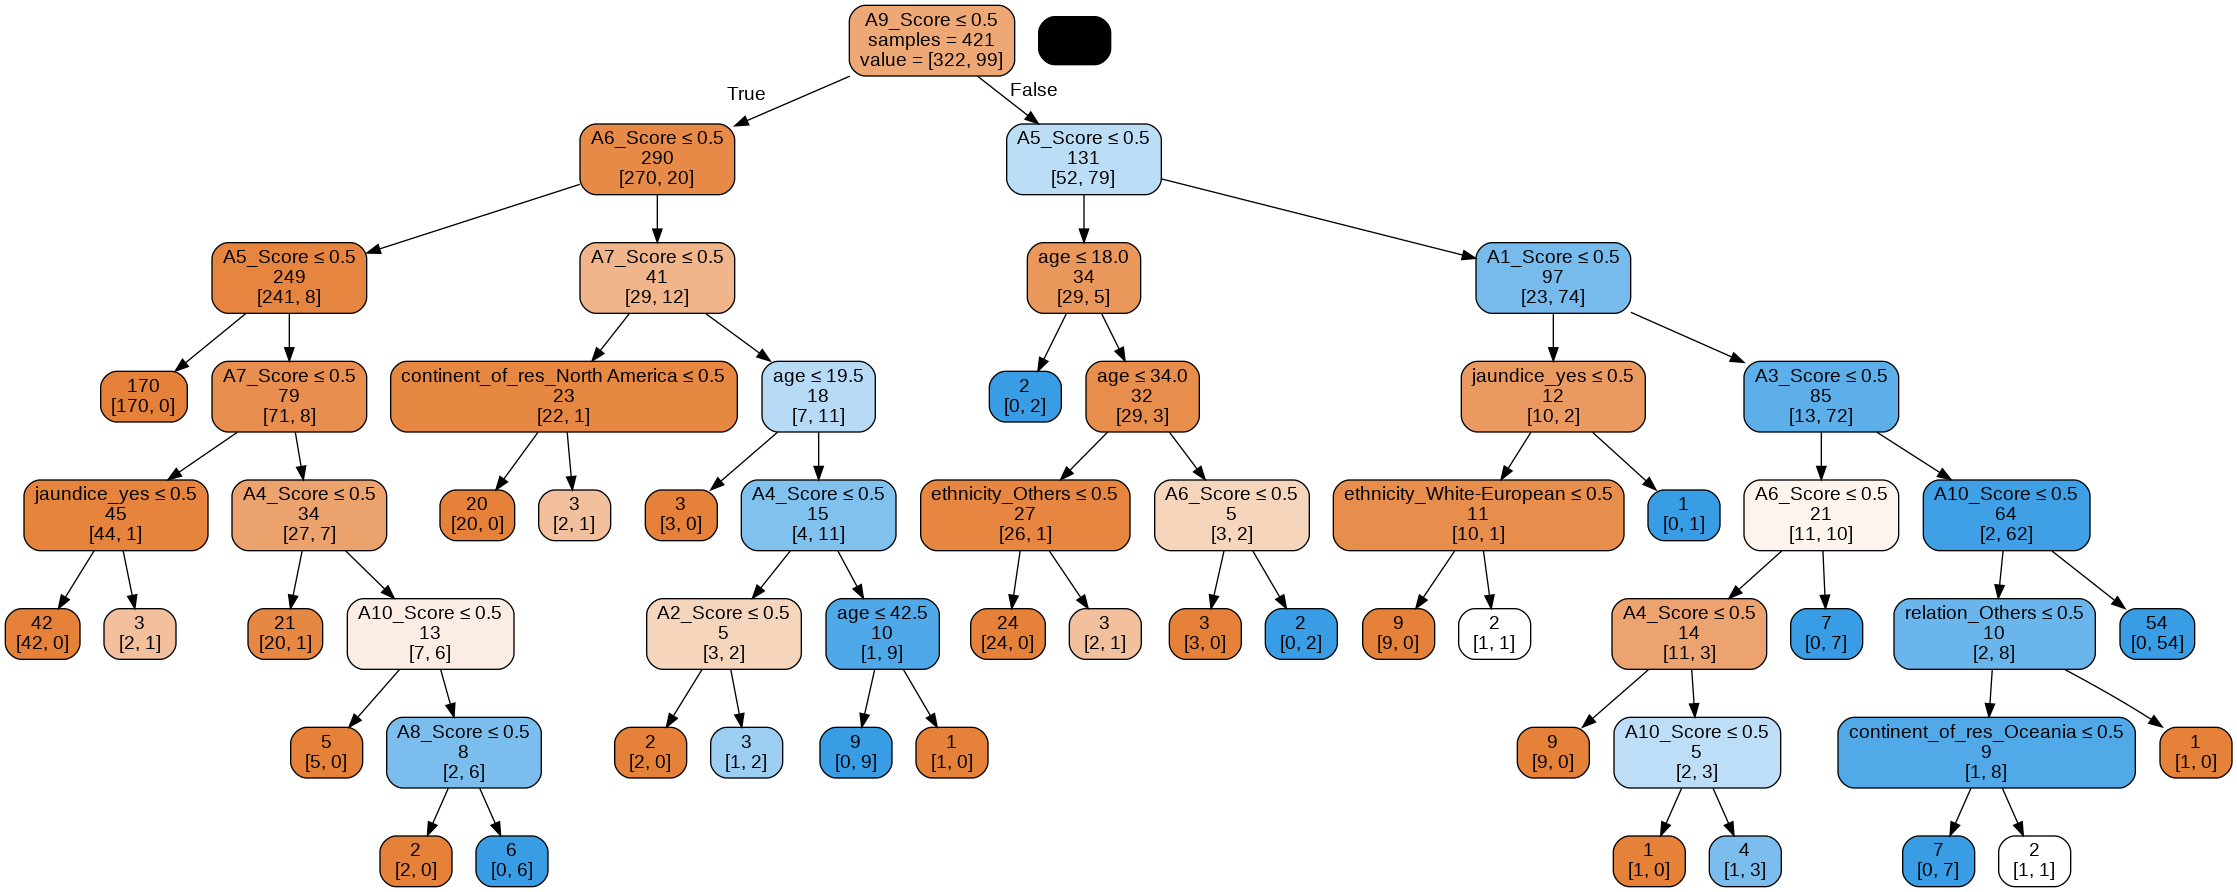

In [ ]:
# Optimize the tree and plot the model
gridContinentTree = DecisionTreeClassifier(max_depth=9, 
                                       min_impurity_decrease=0.001, 
                                       min_samples_split=0.01,
                                       random_state=1)
gridContinentTree.fit(train_X, train_Y)
plotDecisionTree(gridContinentTree, feature_names = train_X.columns)

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, gridContinentTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9113)

       Prediction
Actual   0   1
     0 183   9
     1  16  74


In [ ]:
# Run a linear regression
lin_reg_con = LinearRegression()
lin_reg_con.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check variable coefficients and odds ratios
lin_result_con = pd.DataFrame({'coef': lin_reg_con.coef_[0], 'odds': np.e**lin_reg_con.coef_[0]}, index=X.columns)
print(lin_result_con.sort_values('odds', ascending=False))

                                    coef      odds
ethnicity_Hispanic              0.266503  1.305391
A9_Score                        0.214935  1.239781
A6_Score                        0.202406  1.224345
ethnicity_Latino                0.167463  1.182302
used_app_before_yes             0.164284  1.178549
ethnicity_Black                 0.158620  1.171893
A5_Score                        0.155058  1.167726
A7_Score                        0.146882  1.158217
A3_Score                        0.121090  1.128726
A1_Score                        0.109896  1.116162
A4_Score                        0.099762  1.104908
A2_Score                        0.093761  1.098297
ethnicity_White-European        0.088965  1.093042
continent_of_res_South America  0.080547  1.083880
A8_Score                        0.076172  1.079148
ethnicity_Turkish               0.065397  1.067583
ethnicity_Others                0.065006  1.067166
jaundice_yes                    0.062243  1.064221
A10_Score                      

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

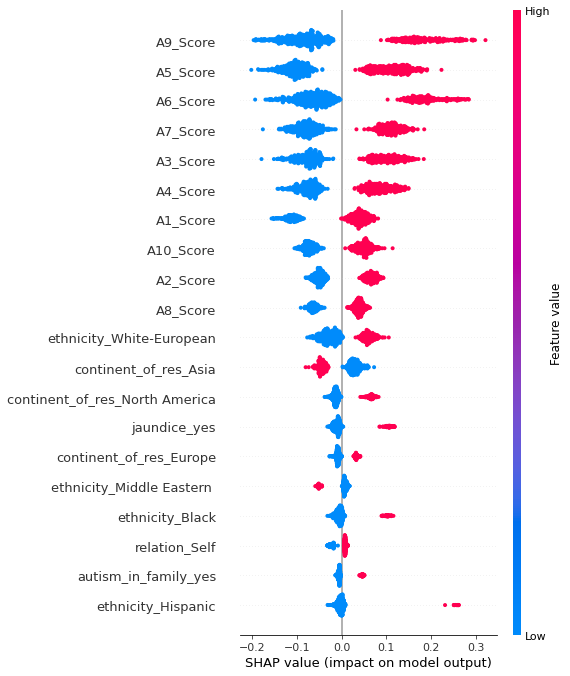

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(lin_reg_con, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Split the dataset with only categorical variables as predictors
predictors = ['age', 'gender', 'ethnicity', 'jaundice', 'autism_in_family', 'continent_of_res', 'used_app_before', 'relation']
x = autism_df[predictors]
y = autism_df['Class_ASD']
# Convert categorical variables to dummies
X = pd.get_dummies(x, drop_first=True)
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Run a maximal tree
fullCatTree = DecisionTreeClassifier(random_state=1)
fullCatTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, fullCatTree.predict(valid_X))

Confusion Matrix (Accuracy 0.6525)

       Prediction
Actual   0   1
     0 157  35
     1  63  27


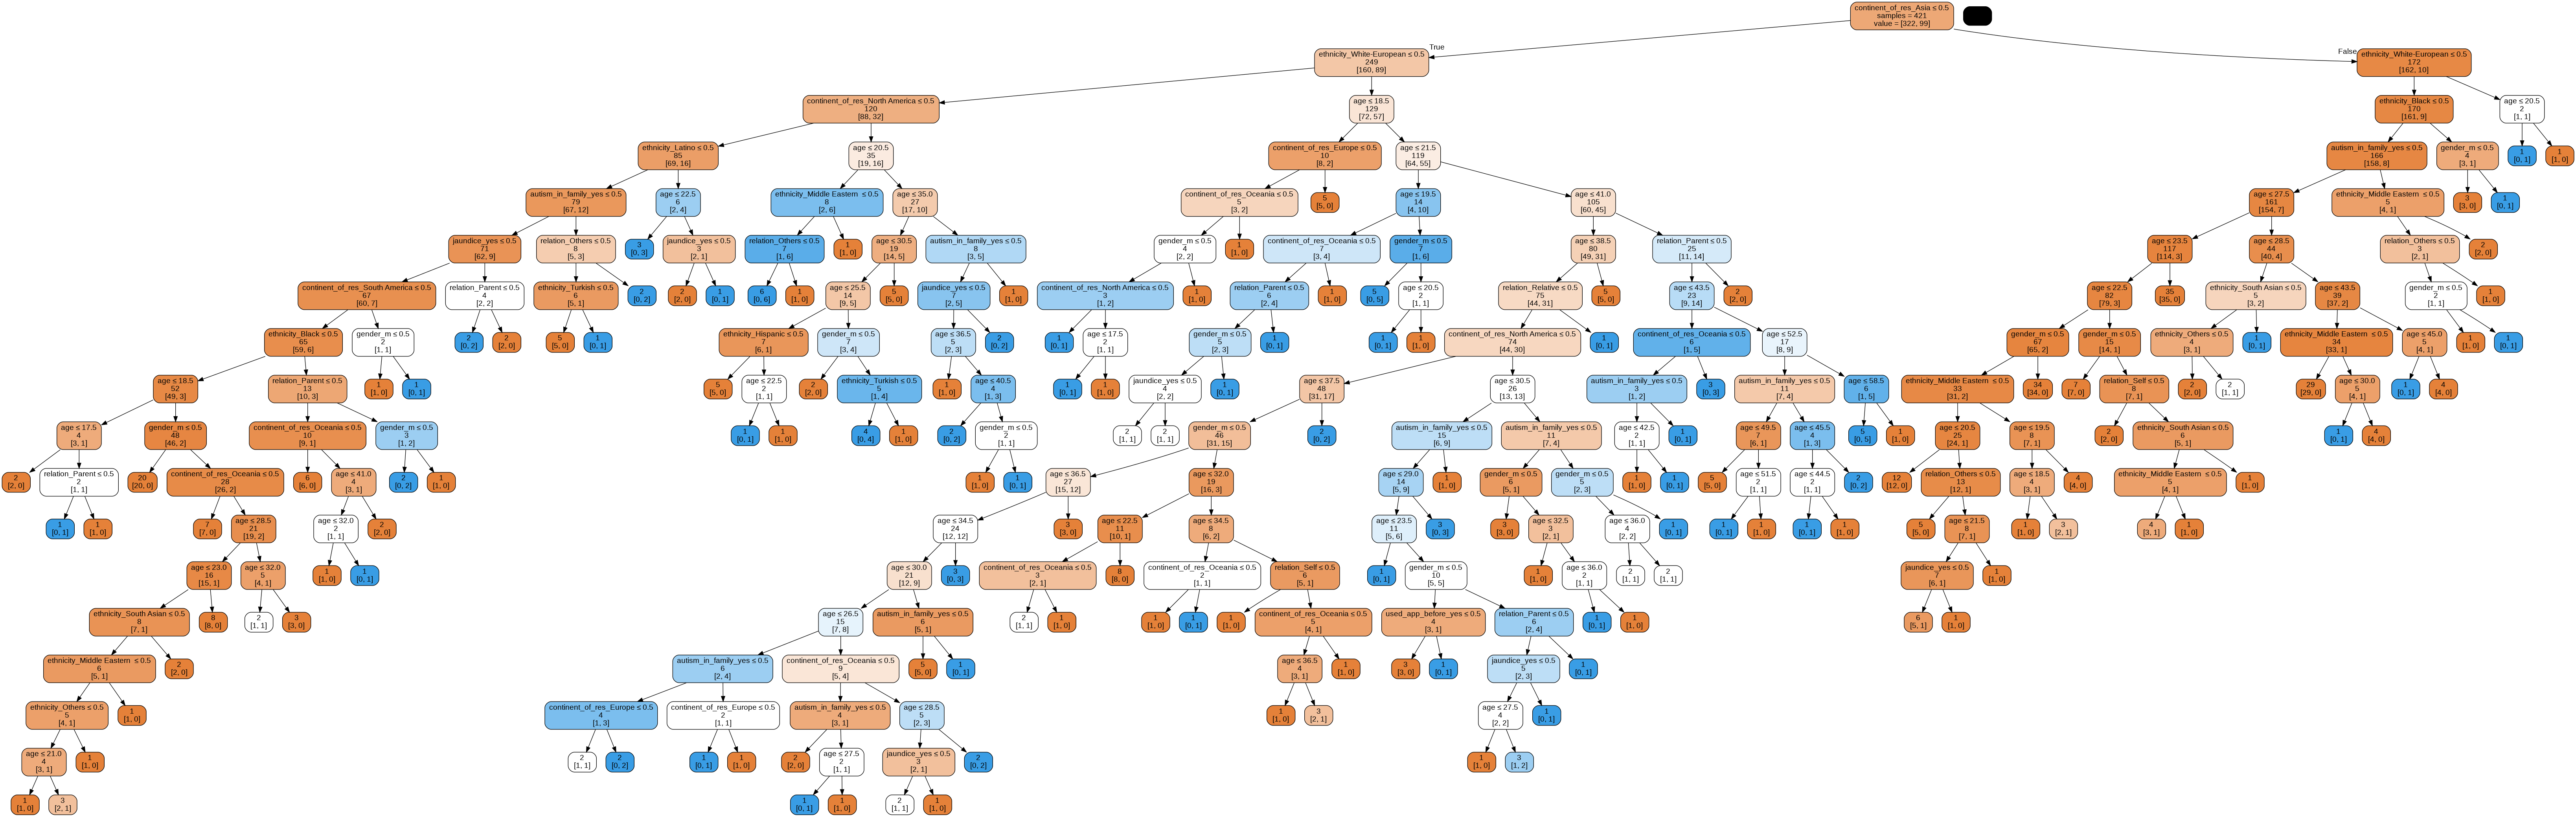

In [ ]:
# Plot the tree
plotDecisionTree(fullCatTree, feature_names=train_X.columns)

In [ ]:
# Create parameters to optimize the decision tree
param_grid = {
    'max_depth':[3, 4, 5, 7, 8],
    'min_samples_split': [0.07, 0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.07, 0.05, 0.02, 0.01, 0.001]
} 

In [ ]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 7, 8],
                         'min_impurity_decrease': [0.07, 0.05, 0.02, 0.01,
                                                   0.001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.001]})

In [ ]:
# Check the best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.07, 'min_samples_split': 0.07}

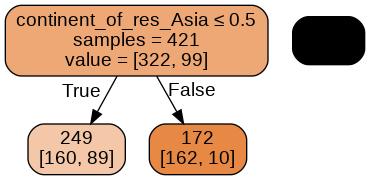

In [ ]:
# Optimize the tree and plot the model
gridCatTree = DecisionTreeClassifier(max_depth=3, 
                                     min_impurity_decrease=0.01, 
                                     min_samples_split=0.01,
                                     random_state=1)
gridCatTree.fit(train_X, train_Y)
plotDecisionTree(gridCatTree, feature_names = train_X.columns)

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, gridCatTree.predict(valid_X))

Confusion Matrix (Accuracy 0.6809)

       Prediction
Actual   0   1
     0 192   0
     1  90   0


In [ ]:
# Split the dataset with only _Score variables as predictors
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
x = autism_df[predictors]
y = autism_df['Class_ASD']
# Convert categorical variables to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Run a maximal tree
fullScoreTree = DecisionTreeClassifier(random_state=1)
fullScoreTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check model accuracy
classificationSummary(train_Y, fullScoreTree.predict(train_X))
classificationSummary(valid_Y, fullScoreTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 322   0
     1   0  99
Confusion Matrix (Accuracy 0.9397)

       Prediction
Actual   0   1
     0 186   6
     1  11  79


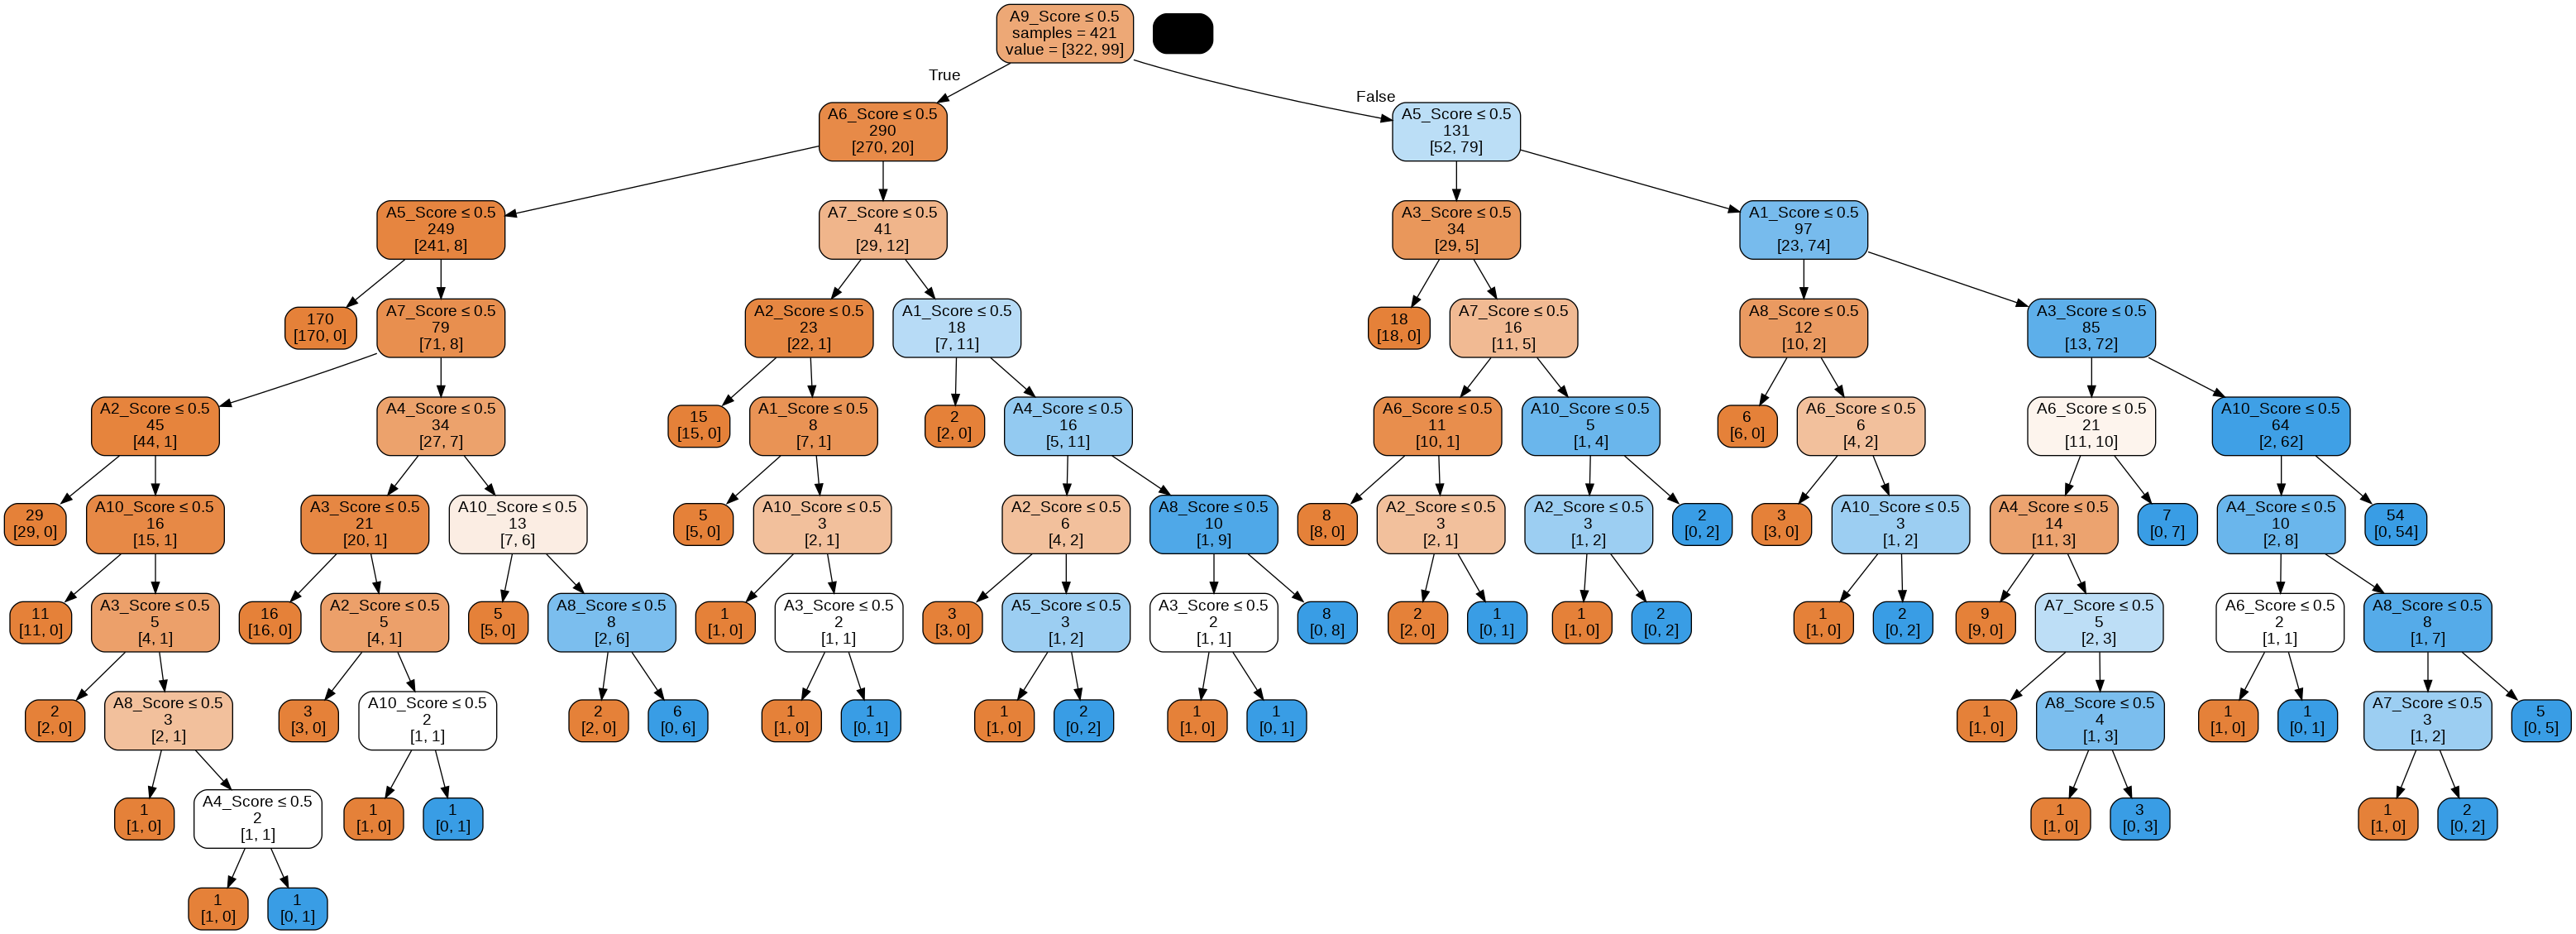

In [ ]:
# Plot the tree
plotDecisionTree(fullScoreTree, feature_names=train_X.columns)

In [ ]:
# Create parameters to optimize the decision tree
param_grid = {
    'max_depth':[3, 4, 5, 7, 8],
    'min_samples_split': [0.05, 0.01, 0.001, 0.005],
    'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001, 0.005]
} 

In [ ]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 7, 8],
                         'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001,
                                                   0.005],
                         'min_samples_split': [0.05, 0.01, 0.001, 0.005]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 8, 'min_impurity_decrease': 0.001, 'min_samples_split': 0.001}

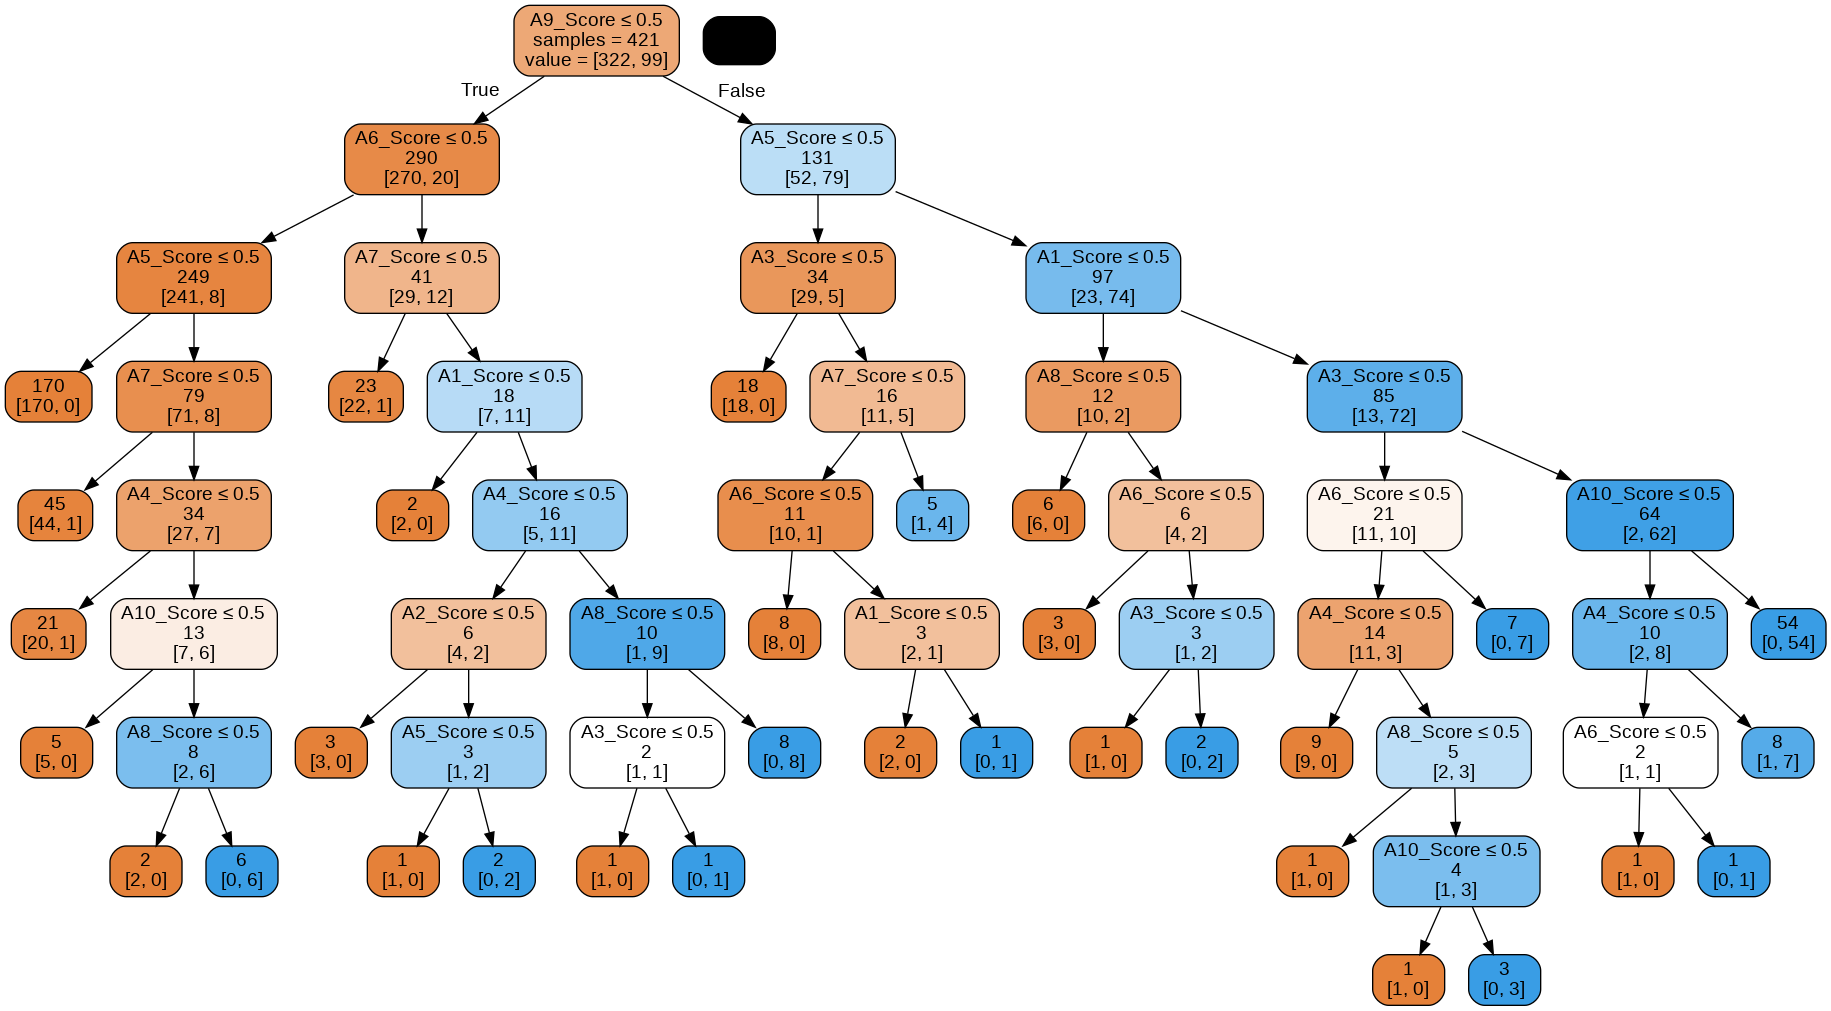

In [ ]:
# Optimize the tree and plot the model
gridScoreTree = DecisionTreeClassifier(max_depth=8, 
                                     min_impurity_decrease=0.001, 
                                     min_samples_split=0.001,
                                     random_state=1)
gridScoreTree.fit(train_X, train_Y)
plotDecisionTree(gridScoreTree, feature_names = train_X.columns)

In [ ]:
# Check model accuracy
classificationSummary(train_Y, gridScoreTree.predict(train_X))
classificationSummary(valid_Y, gridScoreTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9881)

       Prediction
Actual   0   1
     0 320   2
     1   3  96
Confusion Matrix (Accuracy 0.9326)

       Prediction
Actual   0   1
     0 186   6
     1  13  77


In [ ]:
# Set random forest parameters 
param_grid = {
    'max_depth':[5, 6, 8, 9],
    'min_samples_split': [0.01, 0.001, 0.005],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[300, 400, 500]
} 

In [ ]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 8, 9],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.01, 0.001, 0.005],
                         'n_estimators': [300, 400, 500]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 8,
 'min_impurity_decrease': 0.001,
 'min_samples_split': 0.01,
 'n_estimators': 400}

In [ ]:
# Run the random forest
scoreForest = RandomForestClassifier(random_state=1, n_estimators=400, max_depth=8, min_impurity_decrease=0.001, min_samples_split=0.001)
scoreForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=8, min_impurity_decrease=0.001,
                       min_samples_split=0.001, n_estimators=400,
                       random_state=1)

In [ ]:
# Create variables for feature importance and standard deviation
importance = scoreForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in scoreForest.estimators_], axis=0)

In [ ]:
# Check feature importance and standard deviation
scoreForest_df = pd.DataFrame({'feature': train_X.columns,
                   'importance': importance,
                   'std': std})
print(scoreForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.227616  0.141566
4   A5_Score    0.154065  0.102864
5   A6_Score    0.142026  0.119462
2   A3_Score    0.097954  0.078088
3   A4_Score    0.090108  0.068261
6   A7_Score    0.083610  0.053694
0   A1_Score    0.081173  0.051162
9  A10_Score    0.054517  0.041359
1   A2_Score    0.037943  0.028337
7   A8_Score    0.030988  0.022953


Text(0.5, 1.0, 'Visualizing Important Features')

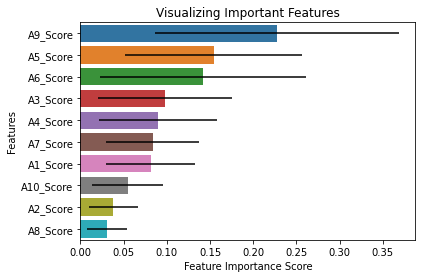

In [ ]:
# Plot feature importance
value_plot = scoreForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [ ]:
# Check model accuracy
classificationSummary(train_Y, scoreForest.predict(train_X))
classificationSummary(valid_Y, scoreForest.predict(valid_X))

Confusion Matrix (Accuracy 0.9905)

       Prediction
Actual   0   1
     0 321   1
     1   3  96
Confusion Matrix (Accuracy 0.9610)

       Prediction
Actual   0   1
     0 190   2
     1   9  81


In [ ]:
# Run a linear regression
score_reg = LinearRegression()
score_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check model coefficients and odds ratio 
print(pd.DataFrame({'coef': score_reg.coef_[0], 'odds': np.e**score_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   0.125228  1.133407
A2_Score   0.115572  1.122515
A3_Score   0.131345  1.140361
A4_Score   0.109007  1.115170
A5_Score   0.148811  1.160454
A6_Score   0.223112  1.249961
A7_Score   0.157096  1.170108
A8_Score   0.078130  1.081263
A9_Score   0.228373  1.256554
A10_Score  0.064828  1.066976


In [ ]:
# Check model accuracy
regressionSummary(train_Y, score_reg.predict(train_X))
regressionSummary(valid_Y, score_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 0.2458
     Mean Absolute Error (MAE) : 0.2000

Regression statistics

               Mean Error (ME) : 0.0226
Root Mean Squared Error (RMSE) : 0.2427
     Mean Absolute Error (MAE) : 0.1935


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

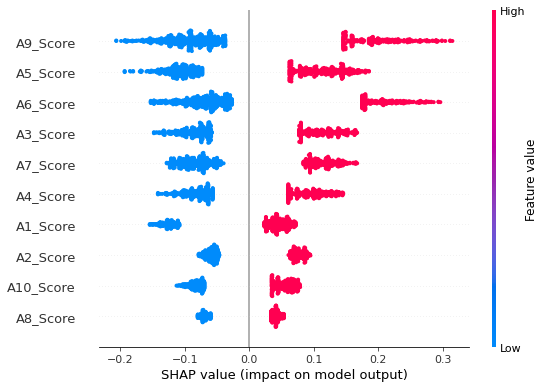

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(score_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Run a logistic regression with C=1
score_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
score_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [ ]:
# Check model accuracy
classificationSummary(train_Y, score_log_reg.predict(train_X))
classificationSummary(valid_Y, score_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9786)

       Prediction
Actual   0   1
     0 319   3
     1   6  93
Confusion Matrix (Accuracy 0.9681)

       Prediction
Actual   0   1
     0 190   2
     1   7  83


In [ ]:
# Check variable coefficients and odds ratio
score_result = pd.DataFrame({'coef': score_log_reg.coef_[0], 'odds': np.e**score_log_reg.coef_[0]}, index=X.columns)
print(score_result.sort_values('odds', ascending=False))

               coef      odds
A9_Score   1.463563  4.321329
A6_Score   1.402261  4.064379
A5_Score   1.351028  3.861394
A7_Score   1.314564  3.723128
A3_Score   1.042488  2.836264
A4_Score   1.013283  2.754629
A1_Score   0.907248  2.477496
A2_Score   0.786157  2.194945
A10_Score  0.690719  1.995149
A8_Score   0.543986  1.722861


In [ ]:
# Create optional hidden layer sizes for neural network
neural_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=neural_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'hidden_layer_sizes': 1}

In [ ]:
# Run a neural network with 3 hidden layers
clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=3, random_state=1)
clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=3, random_state=1,
              solver='lbfgs')

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, clf.predict(valid_X))

Confusion Matrix (Accuracy 0.9965)

       Prediction
Actual   0   1
     0 192   0
     1   1  89


In [ ]:
# Look at model probability prediction
pd.DataFrame(clf.predict_proba(valid_X))

0             1
0    1.000000  2.936072e-30
1    1.000000  1.716808e-25
2    1.000000  1.587530e-26
3    1.000000  8.167031e-25
4    1.000000  8.258144e-27
..        ...           ...
277  1.000000  3.059181e-29
278  1.000000  4.819816e-30
279  0.987030  1.297030e-02
280  1.000000  3.059475e-30
281  0.000001  9.999988e-01

[282 rows x 2 columns]

In [ ]:
# Create a variable for model prediction
pred = clf.predict_proba(valid_X)

<Figure size 720x720 with 0 Axes>

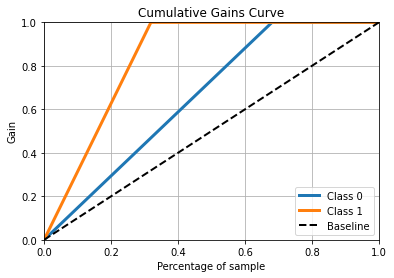

In [ ]:
# Run a cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, pred)
plt.show()